# Connection to drive and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC9'

# Import libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import iqr


import json

import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE
from progressbar import ProgressBar
import h5py






# Data generation or loading

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
device_filter = {
    'vendor':'Juniper',
    'role': 'PE'
}

In [ ]:
events_df = sands.generate_events_time_range(datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S'),datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S')+timedelta(hours=10),parameters1,"all",with_incidents=True)




In [ ]:
events_df

,timestamp,event_name,source,fields,severity,message
0,1664582401,very_high_temperature_log,C-1,"[{""device_name"": ""C-1"", ""ip_address"": ""10.2.1....",warning,2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERT...
402,1664582401,bgp_session_down,tun-1-2-15-2,"[{""device_name"": ""E-1-2"", ""local_address"": ""1....",critical,2022-10-01 00:00:01: bgp_mgr[1463]: %BGP-STATE...
403,1664582401,interface_local_fault,tun-1-2-20-2,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[9654]: %PLATFORM...
404,1664582401,interface_local_fault,tun-1-2-29-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[2239]: %PLATFORM...
405,1664582401,interface_optics_fault,tun-1-2-30-1,"[{""device_name"": ""E-1-2"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: lda_server[1679]: %PKT_IN...
...,...,...,...,...,...,...
40773,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[2294]: %BGP-STATE...
40774,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[8992]: %BGP-STATE...
40775,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 04:59:01: bgp_mgr[3980]: %BGP-STATE...
40777,1664600341,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""12...",info,2022-10-01 04:59:01: bgp_mgr[6973]: %BGP-STATE...


In [ ]:
log_df = events_df[['message','severity']].copy()
log_mask=np.logical_not(log_df['message'].isna())
log_df = log_df[log_mask].copy()
log_list = log_df['message'].to_list()

In [ ]:
with open(join(path_files,'log_messages.txt'), 'w', encoding = "ISO-8859-1") as f:
    f.writelines('\n'.join(log_list))

# Data preparation

In [ ]:
max_len = 210
training_size = 20000
testing_size = 2000
total_subset = training_size+testing_size
log_len = 210
batch_size = 1024
nb_epoch = 20
training_steps_per_epoch = np.ceil(training_size/batch_size)
validation_steps_per_epoch = np.ceil(testing_size/batch_size)
training_file = 'log_messages.txt'

In [ ]:
with open(join(path_files,'c_n_dict_pred.txt'), 'r') as infile:
    c_n_dict=json.load(infile)

with open(join(path_files,'n_c_dict_pred.txt'), 'r') as infile:
    n_c_dict=json.load(infile)
n_c_dict = { int(key):value for key,value in n_c_dict.items()}

In [ ]:
def remove_too_long(log_list):
    training_logs = []
    for log in log_list:
      if len(log)<max_len:
        training_logs.append(log)
    return training_logs

In [ ]:
def tokenize_logs(log_list):
    training_logs_c = []
    for log in log_list:
      training_logs_c.append([char for char in log])
    return training_logs_c

In [ ]:
def one_hot_encode(log_list_c):
    training_array=np.zeros((len(log_list_c),max_len))
    training_array_b=np.zeros((len(log_list_c),max_len,len(c_n_dict)))
    for i in range(len(log_list_c)):
      log = log_list_c[i][:-1]
      log_n = [c_n_dict[c] for c in log]
      log_n += [c_n_dict[' ']]*(max_len-len(log_n))
      training_array[i,:]=log_n
      for j in range(training_array_b.shape[1]):
        training_array_b[i,j,int(training_array[i,j])]=1
    return training_array_b

In [ ]:
def load_data(Train_file, batch_size):
  log_batch = [next(Train_file) for x in range(batch_size)]
  return log_batch

In [ ]:
def batch_generator(Train_file, batch_size, steps):
  idx=1
  with open(Train_file,'r', encoding = "ISO-8859-1") as myfile:
      while True:
        log_batch = load_data(myfile,batch_size)
        log_batch = remove_too_long(log_batch)
        log_batch_b = one_hot_encode(tokenize_logs(log_batch))
        x = log_batch_b
        y = log_batch_b
        yield (x,y)
        if idx < steps:
          idx +=1
        else:
          idx=1

In [ ]:
def data_loader(Train_file, batch_size, steps):
  idx=1
  go_on = True
  x = np.zeros((batch_size*int(steps),max_len,len(c_n_dict)))
  with open(Train_file,'r', encoding = "ISO-8859-1") as myfile:
      while go_on:
        log_batch = load_data(myfile,batch_size)
        log_batch = remove_too_long(log_batch)
        log_batch_b = one_hot_encode(tokenize_logs(log_batch))
        x[(idx-1)*batch_size:idx*batch_size,:,:] = log_batch_b
        if idx < steps:
          idx +=1
        else:
          go_on = False
  return x

In [ ]:
x_train = data_loader(join(path_files,training_file),batch_size,training_steps_per_epoch)

In [ ]:
x_train.shape

(20480, 210, 68)

# Model definition and training

In [ ]:
mymodel = tf.keras.Sequential()
mymodel.add(Bidirectional(LSTM(256, return_sequences=True,recurrent_dropout=0.1),input_shape=(log_len, len(c_n_dict),)))
mymodel.add(Bidirectional(LSTM(256,recurrent_dropout=0.1)))
mymodel.add(layers.RepeatVector(log_len))
mymodel.add(Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.1)))
mymodel.add(layers.TimeDistributed(Dense(len(c_n_dict),activation='softmax')))
mymodel.add(layers.Dropout(0.1))

In [ ]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 210, 512)         665600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (None, 210, 512)         0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (None, 210, 512)         1574912   
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 210, 68)          3

In [ ]:
mymodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
mymodel.load_weights(join(path_files,'weights_autoencoder_best.hdf5'))


In [ ]:
filepath=join(path_files,'weights_autoencoder_best.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = mymodel.fit(x_train,x_train,epochs=nb_epoch,batch_size=128,validation_split=0.1,shuffle = False, verbose=1, callbacks=callbacks_list, use_multiprocessing=True)

Epoch 1/20
144/144 [==============================] - ETA: 0s - loss: 2.2021 - categorical_accuracy: 0.6784
Epoch 1: categorical_accuracy improved from -inf to 0.67840, saving model to /content/drive/MyDrive/Colab Notebooks/practice/weights_autoencoder_256_256_210_11282022_2.best.hdf5
144/144 [==============================] - 334s 2s/step - loss: 2.2021 - categorical_accuracy: 0.6784 - val_loss: 0.6439 - val_categorical_accuracy: 0.7693
Epoch 2/20
144/144 [==============================] - ETA: 0s - loss: 2.1714 - categorical_accuracy: 0.6828
Epoch 2: categorical_accuracy improved from 0.67840 to 0.68277, saving model to /content/drive/MyDrive/Colab Notebooks/practice/weights_autoencoder_256_256_210_11282022_2.best.hdf5
144/144 [==============================] - 322s 2s/step - loss: 2.1714 - categorical_accuracy: 0.6828 - val_loss: 0.6656 - val_categorical_accuracy: 0.7421
Epoch 3/20
144/144 [==============================] - ETA: 0s - loss: 2.1773 - categorical_accuracy: 0.6801
Epoch

In [ ]:
mymodel.save(join(path_files,'log_generator_autoencoder_model'))

# Results evaluation

In [ ]:
score, acc = mymodel.evaluate(x_train, x_train)

640/640 [==============================] - 305s 471ms/step - loss: 0.5412 - categorical_accuracy: 0.8324


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.5411900877952576
Test accuracy: 0.8324011564254761


In [ ]:
y_pred = mymodel.predict(x_train)

640/640 [==============================] - 299s 465ms/step


In [ ]:
y_pred.shape

(20480, 210, 68)

In [ ]:
def binarize_log(generated_log):
  binarized_log = np.zeros(generated_log.shape)
  #max_values = np.max(generated_log,axis=-1)
  for i in range(generated_log.shape[0]):
    #binarized_log[i,:,:] = tf.math.equal(generated_log[i,:,:],max_values[i])
    #print(mask)
    for j in range(generated_log.shape[1]):
      max_value = np.max(generated_log[i,j])
      binarized_log[i,j,:]=np.where(generated_log[i,j,:]==max_value,1,0)
    #for c in log[:]:
    #  max_value = np.max(c)
    #  binarized_log.append([0 if value<max_value else 1 for value in c])
  return binarized_log

In [ ]:
y_pred_b = binarize_log(y_pred[:1000])

In [ ]:
print(y_pred_b)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
print_log(x_train[0:1])

Generated log:  2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERTEMP: C-1 Warning: Intake Left Temperature 43C Exceeds 42C. Please resolve system cooling to prevent system damage                                                   


['2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERTEMP: C-1 Warning: Intake Left Temperature 43C Exceeds 42C. Please resolve system cooling to prevent system damage                                                   ']

In [ ]:
def print_log(binarized_log):
  max_value_index = np.argmax(binarized_log,axis=-1)
  new_logs = []
  for i in range(binarized_log.shape[0]):
    char_list = [n_c_dict[j] for j in max_value_index[i]]
    new_log =''.join(char_list)
    print('Generated log: ',new_log)
    new_logs.append(new_log)
  return new_logs

In [ ]:
print_log(y_pred_b[0:1])
print_log(x_train[0:1])

Generated log:  2022-10-01 02:20:01: %ENVMON-2-IN_OUTLET_OVERTEMP: E----2 Warning: IntakeLLeft Tmmprrtuure 33CExxeeed 42C..Please resolve ssssem oooling    preeent sssttemddaagg                                                 
Generated log:  2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERTEMP: C-1 Warning: Intake Left Temperature 43C Exceeds 42C. Please resolve system cooling to prevent system damage                                                   


['2022-10-01 00:00:01: %ENVMON-2-IN_OUTLET_OVERTEMP: C-1 Warning: Intake Left Temperature 43C Exceeds 42C. Please resolve system cooling to prevent system damage                                                   ']

# Save encoder and decoder

In [ ]:
mymodel.layers

In [ ]:
intermediate_layer_model = keras.Model(inputs=mymodel.input,
                                       outputs=mymodel.layers[1].output)


In [ ]:
intermediate_output = intermediate_layer_model(x_train[0:2000])

In [ ]:
intermediate_output.shape

TensorShape([500, 512])

In [ ]:
intermediate_output[0].numpy().shape

(512,)

In [ ]:
mygen = tf.keras.Sequential()
#mymodel.add(Embedding(input_dim=len(c_vocab),output_dim=100,input_length=max_len))
mygen.add(layers.RepeatVector(log_len,input_shape=(512,)))
mygen.add(Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.1)))
mygen.add(layers.TimeDistributed(Dense(len(c_n_dict),activation='softmax')))
mygen.add(layers.Dropout(0.1))

In [ ]:
mymodel_layer_weights = [layer.get_weights() for layer in mymodel.layers]

In [ ]:
len(mymodel_layer_weights)

6

In [ ]:
encoder_model = tf.keras.Sequential()
encoder_model.add(Bidirectional(LSTM(256, return_sequences=True,recurrent_dropout=0.1),input_shape=(log_len, len(c_n_dict),)))
encoder_model.add(Bidirectional(LSTM(256,recurrent_dropout=0.1)))

In [ ]:
encoder_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 210, 512)         665600    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
Total params: 2,240,512
Trainable params: 2,240,512
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder_model.layers[0].set_weights(mymodel_layer_weights[0])
encoder_model.layers[1].set_weights(mymodel_layer_weights[1])

In [ ]:
encoder_model.save(join(path_files,'log_generator_encoder_model'))

In [ ]:
encoder_model.save_weights(join(path_files,'weights_encoder_best.hdf5'))

In [ ]:
decoder_model = tf.keras.Sequential()
decoder_model.add(layers.RepeatVector(log_len,input_shape=(512,)))
decoder_model.add(Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.1)))
decoder_model.add(layers.TimeDistributed(Dense(len(c_n_dict),activation='softmax')))
decoder_model.add(layers.Dropout(0.1))

In [ ]:
decoder_model.layers[0].set_weights(mymodel_layer_weights[2])
decoder_model.layers[1].set_weights(mymodel_layer_weights[3])
decoder_model.layers[2].set_weights(mymodel_layer_weights[4])
decoder_model.layers[3].set_weights(mymodel_layer_weights[5])

In [ ]:
decoder_model.save(join(path_files,'log_generator_decoder_model'))

In [ ]:
decoder_model.save_weights(join(path_files,'weights_decoder_best.hdf5'))

In [ ]:
mygen.layers[0].set_weights(mymodel_layer_weights[2])
mygen.layers[1].set_weights(mymodel_layer_weights[3])
mygen.layers[2].set_weights(mymodel_layer_weights[4])
mygen.layers[3].set_weights(mymodel_layer_weights[5])

In [ ]:
mygen.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector_3 (RepeatVect  (None, 210, 512)         0         
 or)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 210, 512)         1574912   
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 210, 68)          34884     
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 210, 68)           0         
                                                                 
Total params: 1,609,796
Trainable params: 1,609,796
Non-trainable params: 0
____________________________________________

In [ ]:
y_pred2 = mygen(intermediate_output[1:2].numpy())

In [ ]:
y_pred2_b = binarize_log(y_pred2)
print_log(y_pred2_b[0:1])

Generated log:  2022-10-01 02:20:01: bgp_mgr[2222]: %BGP-STATE_MGR-3-STATE_CHANGE_EVENT : BGP session to 11......./30 channed stttett     nn  deevce  ---                                                                         


['2022-10-01 02:20:01: bgp_mgr[2222]: %BGP-STATE_MGR-3-STATE_CHANGE_EVENT : BGP session to 11......./30 channed stttett     nn  deevce  ---                                                                         ']

In [ ]:
fake_latent_vector = (intermediate_output[0:1].numpy() + intermediate_output[1:2].numpy())/2

In [ ]:
fake_latent_vector.shape

(1, 512)

In [ ]:
y_pred3 = mygen(fake_latent_vector)

In [ ]:
y_pred3_b = binarize_log(y_pred3)
print_log(y_pred3_b[0:1])

Generated log:  2022-10-01 02:20:01: bgpVmgr[227]]:%%BPTTTEEEMMMRR---TTTTCCHANGEEEVVNN  : BG seeeiitttt  1..........20caaaaaa   aaaaattttooooiiievvvvicccee10                                                                     


['2022-10-01 02:20:01: bgpVmgr[227]]:%%BPTTTEEEMMMRR---TTTTCCHANGEEEVVNN  : BG seeeiitttt  1..........20caaaaaa   aaaaattttooooiiievvvvicccee10                                                                     ']

In [ ]:
def find_accuracy(y_test,y_pred):
  length = y_test.shape[1]
  accurate_pred = np.zeros(length)
  total_pred = y_test.shape[0]
  for i in range(y_test.shape[0]):
    for j in range(length):
      if np.array_equal(y_test[i,j,:],y_pred[i,j,:]):
        accurate_pred[j] +=1
  accurate_pred = accurate_pred / total_pred
  return accurate_pred

In [ ]:
accurate_pred = find_accuracy(x_train[:1000],y_pred_b)

Text(0.5, 1.0, 'Log reconstruction accuracy vs character position in log')

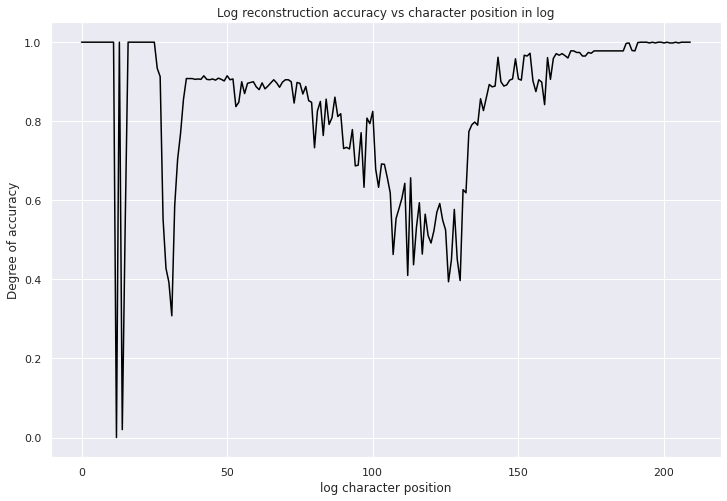

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=range(len(accurate_pred)), y=accurate_pred,color='black')
plt.xlabel('log character position')
plt.ylabel('Degree of accuracy')
plt.title('Log reconstruction accuracy vs character position in log')

# Explore latent space

In [ ]:
log_type = 'if_mgr'
y = []
with open(join(path_files,training_file),'r', encoding = "ISO-8859-1") as myfile:
  for i in range(x_train[:2000].shape[0]):
        log_text = load_data(myfile, 1,1)
        if log_type in log_text[0]:
          y.append('r')
        else:
          y.append('b')


In [ ]:
print(y)

['b', 'r', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',

In [ ]:
latent_output = encoder_model(x_train[0:2000])
tsne = TSNE(n_components=2)
latent_embedded = tsne.fit_transform(latent_output.numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


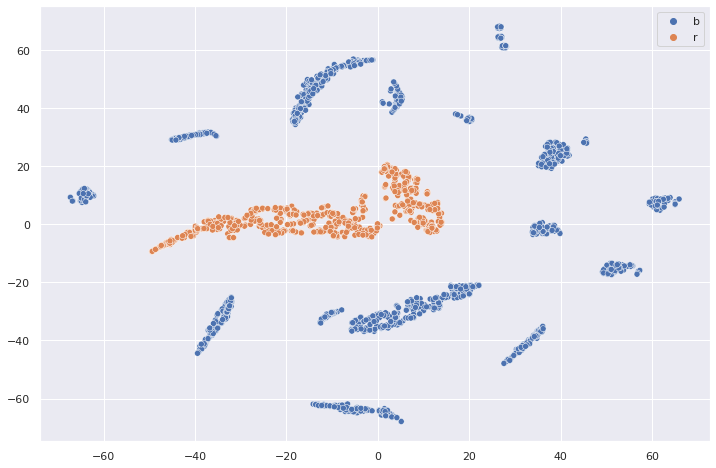

In [ ]:
sns.scatterplot(latent_embedded[:,0], latent_embedded[:,1],hue=y, legend='full')

In [ ]:
encoder_model = tf.keras.Sequential()
encoder_model.add(Bidirectional(LSTM(256, return_sequences=True,recurrent_dropout=0.1),input_shape=(log_len, len(c_n_dict),)))
encoder_model.add(Bidirectional(LSTM(256,recurrent_dropout=0.1)))

In [ ]:
encoder_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 210, 512)         665600    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
Total params: 2,240,512
Trainable params: 2,240,512
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder_model.layers[0].set_weights(mymodel_layer_weights[0])
encoder_model.layers[1].set_weights(mymodel_layer_weights[1])

In [ ]:
encoder_model.save(join(path_files,'log_generator_encoder_model'))

In [ ]:
encoder_model.save_weights(join(path_files,'weights_encoder_best.hdf5'))

In [ ]:
decoder_model = tf.keras.Sequential()
decoder_model.add(layers.RepeatVector(log_len,input_shape=(512,)))
decoder_model.add(Bidirectional(LSTM(256,return_sequences=True,recurrent_dropout=0.1)))
decoder_model.add(layers.TimeDistributed(Dense(len(c_n_dict),activation='softmax')))
decoder_model.add(layers.Dropout(0.1))

In [ ]:
decoder_model.layers[0].set_weights(mymodel_layer_weights[2])
decoder_model.layers[1].set_weights(mymodel_layer_weights[3])
decoder_model.layers[2].set_weights(mymodel_layer_weights[4])
decoder_model.layers[3].set_weights(mymodel_layer_weights[5])

In [ ]:
decoder_model.save(join(path_files,'log_generator_decoder_model'))

In [ ]:
decoder_model.save_weights(join(path_files,'weights_decoder_best.hdf5'))

In [ ]:
pbar = ProgressBar()
x_train_latent = np.zeros((x_train.shape[0],512))
for i in pbar(range(int(x_train.shape[0]/100))):
    x_train_latent[i*100:(i*100+100)] = encoder_model.predict(x_train[i*100:(i*100+100)])

N/A% (0 of 204) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

4/4 [==============================] - 2s 277ms/step


  0% (1 of 204) |                        | Elapsed Time: 0:00:02 ETA:   0:07:39

4/4 [==============================] - 1s 272ms/step


  0% (2 of 204) |                        | Elapsed Time: 0:00:03 ETA:   0:05:46

4/4 [==============================] - 1s 285ms/step


  1% (3 of 204) |                        | Elapsed Time: 0:00:04 ETA:   0:04:09

4/4 [==============================] - 1s 282ms/step


  1% (4 of 204) |                        | Elapsed Time: 0:00:06 ETA:   0:04:24

4/4 [==============================] - 1s 267ms/step


  2% (5 of 204) |                        | Elapsed Time: 0:00:07 ETA:   0:04:04

4/4 [==============================] - 1s 282ms/step


  2% (6 of 204) |                        | Elapsed Time: 0:00:08 ETA:   0:03:50

4/4 [==============================] - 1s 289ms/step


  3% (7 of 204) |                        | Elapsed Time: 0:00:09 ETA:   0:03:57

4/4 [==============================] - 1s 278ms/step


  3% (8 of 204) |                        | Elapsed Time: 0:00:10 ETA:   0:04:10

4/4 [==============================] - 1s 282ms/step


  4% (9 of 204) |#                       | Elapsed Time: 0:00:12 ETA:   0:04:20

4/4 [==============================] - 1s 279ms/step


  4% (10 of 204) |#                      | Elapsed Time: 0:00:13 ETA:   0:04:18

4/4 [==============================] - 1s 268ms/step


  5% (11 of 204) |#                      | Elapsed Time: 0:00:14 ETA:   0:04:14

4/4 [==============================] - 1s 265ms/step


  5% (12 of 204) |#                      | Elapsed Time: 0:00:16 ETA:   0:04:12

4/4 [==============================] - 1s 267ms/step


  6% (13 of 204) |#                      | Elapsed Time: 0:00:17 ETA:   0:04:11

4/4 [==============================] - 1s 274ms/step


  6% (14 of 204) |#                      | Elapsed Time: 0:00:18 ETA:   0:03:57

4/4 [==============================] - 1s 277ms/step


  7% (15 of 204) |#                      | Elapsed Time: 0:00:19 ETA:   0:03:42

4/4 [==============================] - 1s 257ms/step


  7% (16 of 204) |#                      | Elapsed Time: 0:00:21 ETA:   0:03:54

4/4 [==============================] - 1s 274ms/step


  8% (17 of 204) |#                      | Elapsed Time: 0:00:22 ETA:   0:03:52

4/4 [==============================] - 1s 277ms/step


  8% (18 of 204) |##                     | Elapsed Time: 0:00:23 ETA:   0:03:51

4/4 [==============================] - 1s 281ms/step


  9% (19 of 204) |##                     | Elapsed Time: 0:00:24 ETA:   0:03:52

4/4 [==============================] - 1s 277ms/step


  9% (20 of 204) |##                     | Elapsed Time: 0:00:26 ETA:   0:03:51

4/4 [==============================] - 1s 273ms/step


 10% (21 of 204) |##                     | Elapsed Time: 0:00:27 ETA:   0:04:01

4/4 [==============================] - 1s 277ms/step


 10% (22 of 204) |##                     | Elapsed Time: 0:00:28 ETA:   0:04:00

4/4 [==============================] - 1s 273ms/step


 11% (23 of 204) |##                     | Elapsed Time: 0:00:30 ETA:   0:03:43

4/4 [==============================] - 1s 283ms/step


 11% (24 of 204) |##                     | Elapsed Time: 0:00:31 ETA:   0:03:42

4/4 [==============================] - 1s 278ms/step


 12% (25 of 204) |##                     | Elapsed Time: 0:00:32 ETA:   0:03:44

4/4 [==============================] - 1s 273ms/step


 12% (26 of 204) |##                     | Elapsed Time: 0:00:33 ETA:   0:03:28

4/4 [==============================] - 1s 274ms/step


 13% (27 of 204) |###                    | Elapsed Time: 0:00:34 ETA:   0:03:26

4/4 [==============================] - 1s 279ms/step


 13% (28 of 204) |###                    | Elapsed Time: 0:00:36 ETA:   0:03:26

4/4 [==============================] - 1s 281ms/step


 14% (29 of 204) |###                    | Elapsed Time: 0:00:37 ETA:   0:03:37

4/4 [==============================] - 1s 273ms/step


 14% (30 of 204) |###                    | Elapsed Time: 0:00:38 ETA:   0:03:36

4/4 [==============================] - 1s 280ms/step


 15% (31 of 204) |###                    | Elapsed Time: 0:00:39 ETA:   0:03:36

4/4 [==============================] - 1s 291ms/step


 15% (32 of 204) |###                    | Elapsed Time: 0:00:41 ETA:   0:03:47

4/4 [==============================] - 1s 285ms/step


 16% (33 of 204) |###                    | Elapsed Time: 0:00:42 ETA:   0:03:45

4/4 [==============================] - 1s 273ms/step


 16% (34 of 204) |###                    | Elapsed Time: 0:00:43 ETA:   0:03:32

4/4 [==============================] - 1s 262ms/step


 17% (35 of 204) |###                    | Elapsed Time: 0:00:44 ETA:   0:03:30

4/4 [==============================] - 1s 279ms/step


 17% (36 of 204) |####                   | Elapsed Time: 0:00:46 ETA:   0:03:40

4/4 [==============================] - 1s 277ms/step


 18% (37 of 204) |####                   | Elapsed Time: 0:00:47 ETA:   0:03:27

4/4 [==============================] - 1s 271ms/step


 18% (38 of 204) |####                   | Elapsed Time: 0:00:48 ETA:   0:03:14

4/4 [==============================] - 1s 277ms/step


 19% (39 of 204) |####                   | Elapsed Time: 0:00:49 ETA:   0:03:24

4/4 [==============================] - 1s 288ms/step


 19% (40 of 204) |####                   | Elapsed Time: 0:00:51 ETA:   0:03:35

4/4 [==============================] - 1s 284ms/step


 20% (41 of 204) |####                   | Elapsed Time: 0:00:52 ETA:   0:03:25

4/4 [==============================] - 2s 589ms/step


 20% (42 of 204) |####                   | Elapsed Time: 0:00:54 ETA:   0:05:41

4/4 [==============================] - 2s 283ms/step


 21% (43 of 204) |####                   | Elapsed Time: 0:00:57 ETA:   0:07:14

4/4 [==============================] - 1s 275ms/step


 21% (44 of 204) |####                   | Elapsed Time: 0:00:58 ETA:   0:05:20

4/4 [==============================] - 1s 288ms/step


 22% (45 of 204) |#####                  | Elapsed Time: 0:00:59 ETA:   0:03:29

4/4 [==============================] - 1s 283ms/step


 22% (46 of 204) |#####                  | Elapsed Time: 0:01:01 ETA:   0:03:20

4/4 [==============================] - 1s 281ms/step


 23% (47 of 204) |#####                  | Elapsed Time: 0:01:02 ETA:   0:03:18

4/4 [==============================] - 1s 272ms/step


 23% (48 of 204) |#####                  | Elapsed Time: 0:01:03 ETA:   0:03:25

4/4 [==============================] - 1s 277ms/step


 24% (49 of 204) |#####                  | Elapsed Time: 0:01:04 ETA:   0:03:13

4/4 [==============================] - 1s 262ms/step


 24% (50 of 204) |#####                  | Elapsed Time: 0:01:06 ETA:   0:03:11

4/4 [==============================] - 1s 266ms/step


 25% (51 of 204) |#####                  | Elapsed Time: 0:01:07 ETA:   0:03:07

4/4 [==============================] - 1s 270ms/step


 25% (52 of 204) |#####                  | Elapsed Time: 0:01:08 ETA:   0:02:53

4/4 [==============================] - 1s 279ms/step


 25% (53 of 204) |#####                  | Elapsed Time: 0:01:09 ETA:   0:03:06

4/4 [==============================] - 1s 272ms/step


 26% (54 of 204) |######                 | Elapsed Time: 0:01:11 ETA:   0:03:17

4/4 [==============================] - 1s 278ms/step


 26% (55 of 204) |######                 | Elapsed Time: 0:01:12 ETA:   0:03:17

4/4 [==============================] - 1s 264ms/step


 27% (56 of 204) |######                 | Elapsed Time: 0:01:13 ETA:   0:03:02

4/4 [==============================] - 1s 270ms/step


 27% (57 of 204) |######                 | Elapsed Time: 0:01:14 ETA:   0:03:00

4/4 [==============================] - 1s 282ms/step


 28% (58 of 204) |######                 | Elapsed Time: 0:01:16 ETA:   0:03:03

4/4 [==============================] - 1s 278ms/step


 28% (59 of 204) |######                 | Elapsed Time: 0:01:17 ETA:   0:02:54

4/4 [==============================] - 1s 279ms/step


 29% (60 of 204) |######                 | Elapsed Time: 0:01:18 ETA:   0:02:51

4/4 [==============================] - 1s 292ms/step


 29% (61 of 204) |######                 | Elapsed Time: 0:01:19 ETA:   0:02:51

4/4 [==============================] - 1s 275ms/step


 30% (62 of 204) |######                 | Elapsed Time: 0:01:21 ETA:   0:03:01

4/4 [==============================] - 1s 288ms/step


 30% (63 of 204) |#######                | Elapsed Time: 0:01:22 ETA:   0:02:59

4/4 [==============================] - 1s 282ms/step


 31% (64 of 204) |#######                | Elapsed Time: 0:01:23 ETA:   0:02:57

4/4 [==============================] - 1s 283ms/step


 31% (65 of 204) |#######                | Elapsed Time: 0:01:24 ETA:   0:03:03

4/4 [==============================] - 1s 278ms/step


 32% (66 of 204) |#######                | Elapsed Time: 0:01:26 ETA:   0:02:51

4/4 [==============================] - 1s 282ms/step


 32% (67 of 204) |#######                | Elapsed Time: 0:01:27 ETA:   0:02:41

4/4 [==============================] - 1s 259ms/step


 33% (68 of 204) |#######                | Elapsed Time: 0:01:28 ETA:   0:02:36

4/4 [==============================] - 1s 277ms/step


 33% (69 of 204) |#######                | Elapsed Time: 0:01:29 ETA:   0:02:35

4/4 [==============================] - 1s 281ms/step


 34% (70 of 204) |#######                | Elapsed Time: 0:01:31 ETA:   0:03:09

4/4 [==============================] - 2s 420ms/step


 34% (71 of 204) |########               | Elapsed Time: 0:01:33 ETA:   0:03:46

4/4 [==============================] - 2s 414ms/step


 35% (72 of 204) |########               | Elapsed Time: 0:01:35 ETA:   0:05:44

4/4 [==============================] - 1s 275ms/step


 35% (73 of 204) |########               | Elapsed Time: 0:01:36 ETA:   0:04:07

4/4 [==============================] - 1s 273ms/step


 36% (74 of 204) |########               | Elapsed Time: 0:01:38 ETA:   0:02:41

4/4 [==============================] - 1s 275ms/step


 36% (75 of 204) |########               | Elapsed Time: 0:01:39 ETA:   0:02:49

4/4 [==============================] - 1s 262ms/step


 37% (76 of 204) |########               | Elapsed Time: 0:01:40 ETA:   0:02:48

4/4 [==============================] - 1s 277ms/step


 37% (77 of 204) |########               | Elapsed Time: 0:01:41 ETA:   0:02:38

4/4 [==============================] - 1s 270ms/step


 38% (78 of 204) |########               | Elapsed Time: 0:01:43 ETA:   0:02:36

4/4 [==============================] - 1s 281ms/step


 38% (79 of 204) |########               | Elapsed Time: 0:01:44 ETA:   0:02:36

4/4 [==============================] - 1s 272ms/step


 39% (80 of 204) |#########              | Elapsed Time: 0:01:45 ETA:   0:02:25

4/4 [==============================] - 1s 269ms/step


 39% (81 of 204) |#########              | Elapsed Time: 0:01:46 ETA:   0:02:21

4/4 [==============================] - 1s 270ms/step


 40% (82 of 204) |#########              | Elapsed Time: 0:01:48 ETA:   0:02:29

4/4 [==============================] - 1s 265ms/step


 40% (83 of 204) |#########              | Elapsed Time: 0:01:49 ETA:   0:02:28

4/4 [==============================] - 1s 272ms/step


 41% (84 of 204) |#########              | Elapsed Time: 0:01:50 ETA:   0:02:18

4/4 [==============================] - 1s 279ms/step


 41% (85 of 204) |#########              | Elapsed Time: 0:01:51 ETA:   0:02:28

4/4 [==============================] - 1s 284ms/step


 42% (86 of 204) |#########              | Elapsed Time: 0:01:52 ETA:   0:02:35

4/4 [==============================] - 1s 275ms/step


 42% (87 of 204) |#########              | Elapsed Time: 0:01:54 ETA:   0:02:33

4/4 [==============================] - 1s 269ms/step


 43% (88 of 204) |#########              | Elapsed Time: 0:01:55 ETA:   0:02:22

4/4 [==============================] - 1s 260ms/step


 43% (89 of 204) |##########             | Elapsed Time: 0:01:56 ETA:   0:02:10

4/4 [==============================] - 1s 281ms/step


 44% (90 of 204) |##########             | Elapsed Time: 0:01:57 ETA:   0:02:11

4/4 [==============================] - 1s 278ms/step


 44% (91 of 204) |##########             | Elapsed Time: 0:01:59 ETA:   0:02:21

4/4 [==============================] - 1s 283ms/step


 45% (92 of 204) |##########             | Elapsed Time: 0:02:00 ETA:   0:02:27

4/4 [==============================] - 1s 270ms/step


 45% (93 of 204) |##########             | Elapsed Time: 0:02:01 ETA:   0:02:26

4/4 [==============================] - 1s 274ms/step


 46% (94 of 204) |##########             | Elapsed Time: 0:02:03 ETA:   0:02:25

4/4 [==============================] - 1s 279ms/step


 46% (95 of 204) |##########             | Elapsed Time: 0:02:04 ETA:   0:02:24

4/4 [==============================] - 1s 283ms/step


 47% (96 of 204) |##########             | Elapsed Time: 0:02:05 ETA:   0:02:22

4/4 [==============================] - 1s 281ms/step


 47% (97 of 204) |##########             | Elapsed Time: 0:02:06 ETA:   0:02:14

4/4 [==============================] - 1s 273ms/step


 48% (98 of 204) |###########            | Elapsed Time: 0:02:08 ETA:   0:02:13

4/4 [==============================] - 1s 278ms/step


 48% (99 of 204) |###########            | Elapsed Time: 0:02:09 ETA:   0:02:12

4/4 [==============================] - 1s 269ms/step


 49% (100 of 204) |##########            | Elapsed Time: 0:02:10 ETA:   0:02:10

4/4 [==============================] - 1s 280ms/step


 49% (101 of 204) |##########            | Elapsed Time: 0:02:12 ETA:   0:02:15

4/4 [==============================] - 1s 279ms/step


 50% (102 of 204) |###########           | Elapsed Time: 0:02:13 ETA:   0:02:14

4/4 [==============================] - 1s 284ms/step


 50% (103 of 204) |###########           | Elapsed Time: 0:02:14 ETA:   0:02:13

4/4 [==============================] - 1s 283ms/step


 50% (104 of 204) |###########           | Elapsed Time: 0:02:15 ETA:   0:02:07

4/4 [==============================] - 1s 278ms/step


 51% (105 of 204) |###########           | Elapsed Time: 0:02:17 ETA:   0:02:06

4/4 [==============================] - 1s 279ms/step


 51% (106 of 204) |###########           | Elapsed Time: 0:02:18 ETA:   0:02:09

4/4 [==============================] - 1s 281ms/step


 52% (107 of 204) |###########           | Elapsed Time: 0:02:19 ETA:   0:02:01

4/4 [==============================] - 1s 284ms/step


 52% (108 of 204) |###########           | Elapsed Time: 0:02:21 ETA:   0:02:00

4/4 [==============================] - 1s 270ms/step


 53% (109 of 204) |###########           | Elapsed Time: 0:02:22 ETA:   0:02:05

4/4 [==============================] - 1s 282ms/step


 53% (110 of 204) |###########           | Elapsed Time: 0:02:23 ETA:   0:02:04

4/4 [==============================] - 1s 279ms/step


 54% (111 of 204) |###########           | Elapsed Time: 0:02:24 ETA:   0:02:02

4/4 [==============================] - 1s 280ms/step


 54% (112 of 204) |############          | Elapsed Time: 0:02:26 ETA:   0:01:55

4/4 [==============================] - 1s 275ms/step


 55% (113 of 204) |############          | Elapsed Time: 0:02:27 ETA:   0:01:47

4/4 [==============================] - 1s 275ms/step


 55% (114 of 204) |############          | Elapsed Time: 0:02:28 ETA:   0:01:44

4/4 [==============================] - 1s 282ms/step


 56% (115 of 204) |############          | Elapsed Time: 0:02:29 ETA:   0:01:44

4/4 [==============================] - 1s 282ms/step


 56% (116 of 204) |############          | Elapsed Time: 0:02:31 ETA:   0:01:50

4/4 [==============================] - 1s 273ms/step


 57% (117 of 204) |############          | Elapsed Time: 0:02:32 ETA:   0:01:54

4/4 [==============================] - 1s 286ms/step


 57% (118 of 204) |############          | Elapsed Time: 0:02:33 ETA:   0:01:53

4/4 [==============================] - 1s 283ms/step


 58% (119 of 204) |############          | Elapsed Time: 0:02:34 ETA:   0:01:47

4/4 [==============================] - 1s 275ms/step


 58% (120 of 204) |############          | Elapsed Time: 0:02:36 ETA:   0:01:39

4/4 [==============================] - 1s 277ms/step


 59% (121 of 204) |#############         | Elapsed Time: 0:02:37 ETA:   0:01:42

4/4 [==============================] - 1s 271ms/step


 59% (122 of 204) |#############         | Elapsed Time: 0:02:38 ETA:   0:01:48

4/4 [==============================] - 1s 279ms/step


 60% (123 of 204) |#############         | Elapsed Time: 0:02:39 ETA:   0:01:40

4/4 [==============================] - 1s 281ms/step


 60% (124 of 204) |#############         | Elapsed Time: 0:02:40 ETA:   0:01:33

4/4 [==============================] - 1s 287ms/step


 61% (125 of 204) |#############         | Elapsed Time: 0:02:42 ETA:   0:01:34

4/4 [==============================] - 1s 276ms/step


 61% (126 of 204) |#############         | Elapsed Time: 0:02:43 ETA:   0:01:38

4/4 [==============================] - 1s 267ms/step


 62% (127 of 204) |#############         | Elapsed Time: 0:02:44 ETA:   0:01:41

4/4 [==============================] - 1s 284ms/step


 62% (128 of 204) |#############         | Elapsed Time: 0:02:46 ETA:   0:01:35

4/4 [==============================] - 1s 271ms/step


 63% (129 of 204) |#############         | Elapsed Time: 0:02:47 ETA:   0:01:33

4/4 [==============================] - 1s 262ms/step


 63% (130 of 204) |##############        | Elapsed Time: 0:02:48 ETA:   0:01:38

4/4 [==============================] - 1s 286ms/step


 64% (131 of 204) |##############        | Elapsed Time: 0:02:49 ETA:   0:01:36

4/4 [==============================] - 1s 279ms/step


 64% (132 of 204) |##############        | Elapsed Time: 0:02:51 ETA:   0:01:29

4/4 [==============================] - 1s 276ms/step


 65% (133 of 204) |##############        | Elapsed Time: 0:02:52 ETA:   0:01:28

4/4 [==============================] - 1s 271ms/step


 65% (134 of 204) |##############        | Elapsed Time: 0:02:53 ETA:   0:01:26

4/4 [==============================] - 1s 288ms/step


 66% (135 of 204) |##############        | Elapsed Time: 0:02:54 ETA:   0:01:21

4/4 [==============================] - 1s 279ms/step


 66% (136 of 204) |##############        | Elapsed Time: 0:02:56 ETA:   0:01:20

4/4 [==============================] - 1s 273ms/step


 67% (137 of 204) |##############        | Elapsed Time: 0:02:57 ETA:   0:01:23

4/4 [==============================] - 1s 275ms/step


 67% (138 of 204) |##############        | Elapsed Time: 0:02:58 ETA:   0:01:22

4/4 [==============================] - 1s 282ms/step


 68% (139 of 204) |##############        | Elapsed Time: 0:02:59 ETA:   0:01:17

4/4 [==============================] - 1s 280ms/step


 68% (140 of 204) |###############       | Elapsed Time: 0:03:01 ETA:   0:01:20

4/4 [==============================] - 1s 279ms/step


 69% (141 of 204) |###############       | Elapsed Time: 0:03:02 ETA:   0:01:18

4/4 [==============================] - 1s 285ms/step


 69% (142 of 204) |###############       | Elapsed Time: 0:03:03 ETA:   0:01:17

4/4 [==============================] - 1s 274ms/step


 70% (143 of 204) |###############       | Elapsed Time: 0:03:04 ETA:   0:01:20

4/4 [==============================] - 1s 269ms/step


 70% (144 of 204) |###############       | Elapsed Time: 0:03:05 ETA:   0:01:13

4/4 [==============================] - 1s 273ms/step


 71% (145 of 204) |###############       | Elapsed Time: 0:03:07 ETA:   0:01:07

4/4 [==============================] - 1s 282ms/step


 71% (146 of 204) |###############       | Elapsed Time: 0:03:08 ETA:   0:01:11

4/4 [==============================] - 1s 284ms/step


 72% (147 of 204) |###############       | Elapsed Time: 0:03:09 ETA:   0:01:14

4/4 [==============================] - 1s 279ms/step


 72% (148 of 204) |###############       | Elapsed Time: 0:03:11 ETA:   0:01:13

4/4 [==============================] - 1s 285ms/step


 73% (149 of 204) |################      | Elapsed Time: 0:03:12 ETA:   0:01:13

4/4 [==============================] - 1s 280ms/step


 73% (150 of 204) |################      | Elapsed Time: 0:03:13 ETA:   0:01:08

4/4 [==============================] - 1s 285ms/step


 74% (151 of 204) |################      | Elapsed Time: 0:03:14 ETA:   0:01:03

4/4 [==============================] - 1s 281ms/step


 74% (152 of 204) |################      | Elapsed Time: 0:03:16 ETA:   0:01:02

4/4 [==============================] - 1s 280ms/step


 75% (153 of 204) |################      | Elapsed Time: 0:03:17 ETA:   0:01:01

4/4 [==============================] - 1s 283ms/step


 75% (154 of 204) |################      | Elapsed Time: 0:03:18 ETA:   0:01:00

4/4 [==============================] - 1s 286ms/step


 75% (155 of 204) |################      | Elapsed Time: 0:03:19 ETA:   0:00:59

4/4 [==============================] - 1s 281ms/step


 76% (156 of 204) |################      | Elapsed Time: 0:03:20 ETA:   0:00:57

4/4 [==============================] - 1s 281ms/step


 76% (157 of 204) |################      | Elapsed Time: 0:03:22 ETA:   0:00:55

4/4 [==============================] - 1s 281ms/step


 77% (158 of 204) |#################     | Elapsed Time: 0:03:23 ETA:   0:00:54

4/4 [==============================] - 1s 280ms/step


 77% (159 of 204) |#################     | Elapsed Time: 0:03:24 ETA:   0:00:54

4/4 [==============================] - 1s 284ms/step


 78% (160 of 204) |#################     | Elapsed Time: 0:03:25 ETA:   0:00:55

4/4 [==============================] - 1s 279ms/step


 78% (161 of 204) |#################     | Elapsed Time: 0:03:27 ETA:   0:00:56

4/4 [==============================] - 1s 273ms/step


 79% (162 of 204) |#################     | Elapsed Time: 0:03:28 ETA:   0:00:52

4/4 [==============================] - 1s 266ms/step


 79% (163 of 204) |#################     | Elapsed Time: 0:03:29 ETA:   0:00:50

4/4 [==============================] - 1s 278ms/step


 80% (164 of 204) |#################     | Elapsed Time: 0:03:30 ETA:   0:00:52

4/4 [==============================] - 1s 284ms/step


 80% (165 of 204) |#################     | Elapsed Time: 0:03:32 ETA:   0:00:51

4/4 [==============================] - 1s 283ms/step


 81% (166 of 204) |#################     | Elapsed Time: 0:03:33 ETA:   0:00:47

4/4 [==============================] - 1s 276ms/step


 81% (167 of 204) |##################    | Elapsed Time: 0:03:34 ETA:   0:00:43

4/4 [==============================] - 1s 282ms/step


 82% (168 of 204) |##################    | Elapsed Time: 0:03:35 ETA:   0:00:42

4/4 [==============================] - 1s 276ms/step


 82% (169 of 204) |##################    | Elapsed Time: 0:03:36 ETA:   0:00:41

4/4 [==============================] - 1s 282ms/step


 83% (170 of 204) |##################    | Elapsed Time: 0:03:38 ETA:   0:00:40

4/4 [==============================] - 1s 282ms/step


 83% (171 of 204) |##################    | Elapsed Time: 0:03:39 ETA:   0:00:41

4/4 [==============================] - 1s 280ms/step


 84% (172 of 204) |##################    | Elapsed Time: 0:03:40 ETA:   0:00:42

4/4 [==============================] - 1s 283ms/step


 84% (173 of 204) |##################    | Elapsed Time: 0:03:42 ETA:   0:00:39

4/4 [==============================] - 1s 283ms/step


 85% (174 of 204) |##################    | Elapsed Time: 0:03:43 ETA:   0:00:36

4/4 [==============================] - 1s 277ms/step


 85% (175 of 204) |##################    | Elapsed Time: 0:03:44 ETA:   0:00:34

4/4 [==============================] - 1s 277ms/step


 86% (176 of 204) |##################    | Elapsed Time: 0:03:45 ETA:   0:00:34

4/4 [==============================] - 1s 276ms/step


 86% (177 of 204) |###################   | Elapsed Time: 0:03:46 ETA:   0:00:34

4/4 [==============================] - 1s 285ms/step


 87% (178 of 204) |###################   | Elapsed Time: 0:03:48 ETA:   0:00:31

4/4 [==============================] - 1s 276ms/step


 87% (179 of 204) |###################   | Elapsed Time: 0:03:49 ETA:   0:00:31

4/4 [==============================] - 1s 278ms/step


 88% (180 of 204) |###################   | Elapsed Time: 0:03:50 ETA:   0:00:31

4/4 [==============================] - 1s 276ms/step


 88% (181 of 204) |###################   | Elapsed Time: 0:03:51 ETA:   0:00:28

4/4 [==============================] - 1s 277ms/step


 89% (182 of 204) |###################   | Elapsed Time: 0:03:53 ETA:   0:00:27

4/4 [==============================] - 1s 269ms/step


 89% (183 of 204) |###################   | Elapsed Time: 0:03:54 ETA:   0:00:27

4/4 [==============================] - 1s 280ms/step


 90% (184 of 204) |###################   | Elapsed Time: 0:03:55 ETA:   0:00:25

4/4 [==============================] - 1s 283ms/step


 90% (185 of 204) |###################   | Elapsed Time: 0:03:57 ETA:   0:00:23

4/4 [==============================] - 1s 286ms/step


 91% (186 of 204) |####################  | Elapsed Time: 0:03:58 ETA:   0:00:23

4/4 [==============================] - 1s 284ms/step


 91% (187 of 204) |####################  | Elapsed Time: 0:03:59 ETA:   0:00:21

4/4 [==============================] - 1s 288ms/step


 92% (188 of 204) |####################  | Elapsed Time: 0:04:00 ETA:   0:00:19

4/4 [==============================] - 1s 282ms/step


 92% (189 of 204) |####################  | Elapsed Time: 0:04:02 ETA:   0:00:18

4/4 [==============================] - 1s 275ms/step


 93% (190 of 204) |####################  | Elapsed Time: 0:04:03 ETA:   0:00:16

4/4 [==============================] - 1s 276ms/step


 93% (191 of 204) |####################  | Elapsed Time: 0:04:04 ETA:   0:00:16

4/4 [==============================] - 1s 288ms/step


 94% (192 of 204) |####################  | Elapsed Time: 0:04:05 ETA:   0:00:15

4/4 [==============================] - 1s 294ms/step


 94% (193 of 204) |####################  | Elapsed Time: 0:04:07 ETA:   0:00:14

4/4 [==============================] - 1s 287ms/step


 95% (194 of 204) |####################  | Elapsed Time: 0:04:08 ETA:   0:00:12

4/4 [==============================] - 1s 276ms/step


 95% (195 of 204) |##################### | Elapsed Time: 0:04:09 ETA:   0:00:10

4/4 [==============================] - 1s 284ms/step


 96% (196 of 204) |##################### | Elapsed Time: 0:04:10 ETA:   0:00:10

4/4 [==============================] - 1s 288ms/step


 96% (197 of 204) |##################### | Elapsed Time: 0:04:12 ETA:   0:00:09

4/4 [==============================] - 1s 288ms/step


 97% (198 of 204) |##################### | Elapsed Time: 0:04:13 ETA:   0:00:07

4/4 [==============================] - 1s 275ms/step


 97% (199 of 204) |##################### | Elapsed Time: 0:04:14 ETA:   0:00:06

4/4 [==============================] - 1s 269ms/step


 98% (200 of 204) |##################### | Elapsed Time: 0:04:15 ETA:   0:00:04

4/4 [==============================] - 1s 285ms/step


 98% (201 of 204) |##################### | Elapsed Time: 0:04:17 ETA:   0:00:03

4/4 [==============================] - 1s 282ms/step


 99% (202 of 204) |##################### | Elapsed Time: 0:04:18 ETA:   0:00:02

4/4 [==============================] - 1s 280ms/step


 99% (203 of 204) |##################### | Elapsed Time: 0:04:19 ETA:   0:00:01

4/4 [==============================] - 1s 288ms/step


100% (204 of 204) |######################| Elapsed Time: 0:04:20 Time:  0:04:20


In [ ]:
x_train_latent.shape

(20480, 512)

In [ ]:
training_data_file = 'training_data_binary.h5'
with h5py.File(join(path_files,training_data_file),'w') as hf:
    hf.create_dataset('X_train_latent',data=x_train_latent)


In [ ]:
with h5py.File(join(path_files,training_data_file),'r') as hf:
    X_train_batch = hf['X_train_latent'][0:10,:]
    

In [ ]:
X_train_batch.shape

(10, 512)